In [5]:
# import libraries
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import keras
import datetime
from keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Bidirectional

[Predicting Sequential Data using LSTM: An Introduction](https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816)

In [7]:
streaming=pd.read_csv('cpu4.csv')
for i in range(len(streaming)):
    streaming['timestamp'].iloc[i]=datetime.datetime.fromtimestamp(streaming['timestamp'].iloc[i]) #We are given the timestamp as a unix code
cols=[i for i in streaming.columns if i not in ['timestamp']]
for col in cols:
    streaming[col]=pd.to_numeric(streaming[col])
streaming['timestamp'] = pd.to_datetime(streaming['timestamp'])
streaming.tail()

timestamp     value  label
17563 2016-09-23 19:35:00  0.074292      0
17564 2016-09-23 19:40:00  0.295152      0
17565 2016-09-23 19:45:00  0.074292      0
17566 2016-09-23 19:50:00 -0.146567      0
17567 2016-09-23 19:55:00 -0.036137      0

In [8]:
value=streaming['value']
timestamp=streaming['timestamp']
label=streaming['label']

Text(0.5, 1.0, 'Streaming Dataset')

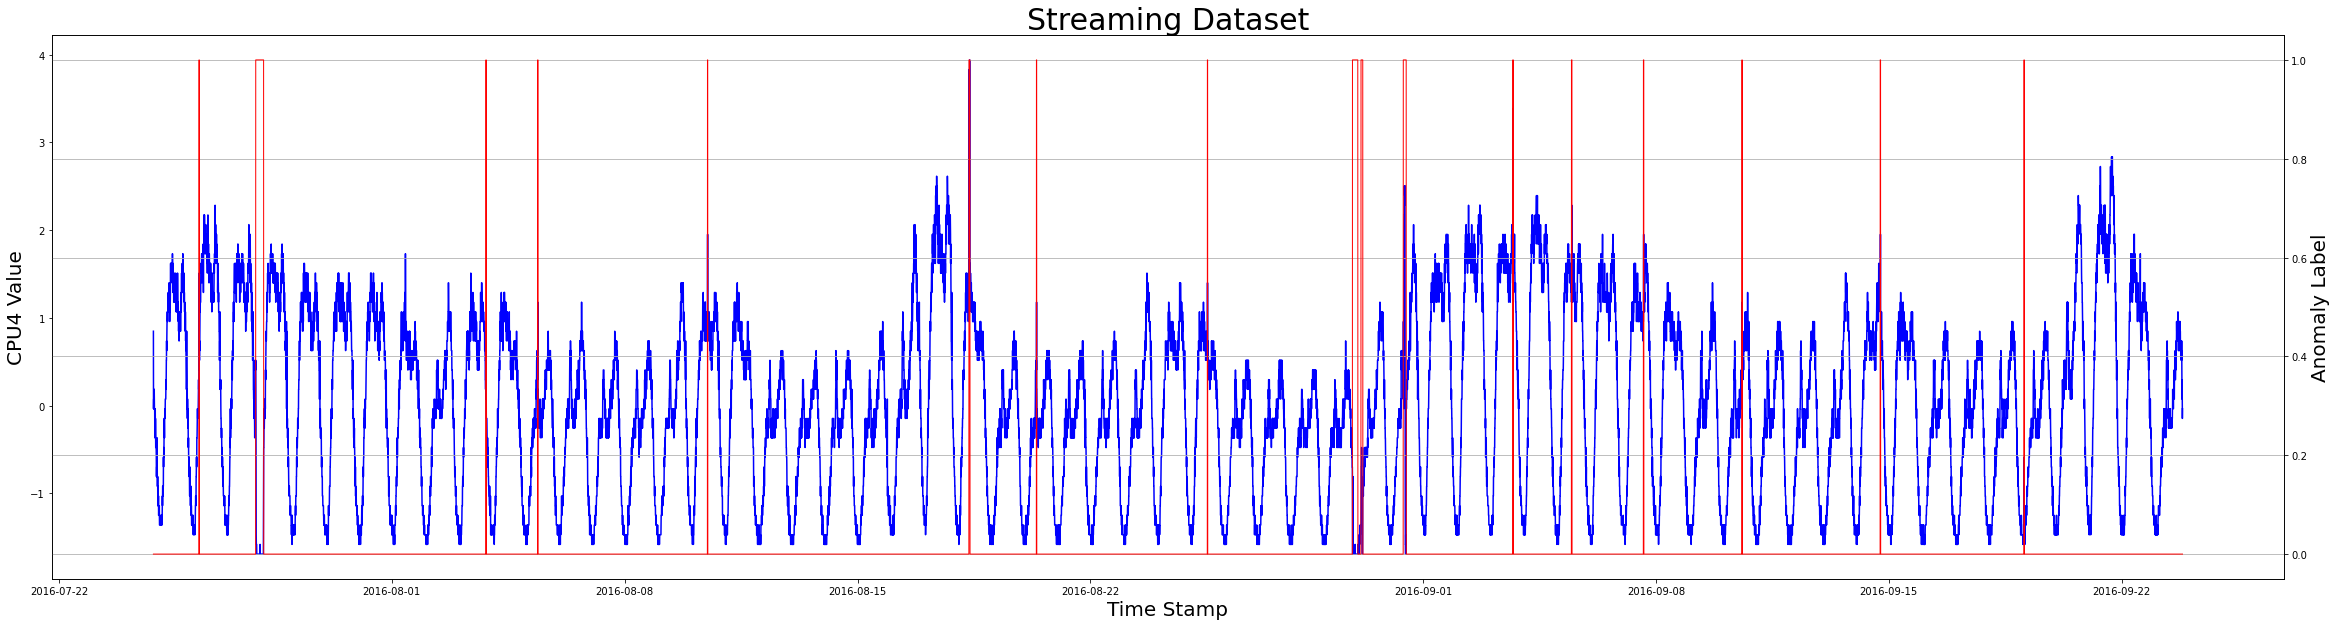

In [9]:
fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(timestamp, value, color='blue')
ax2a.plot(timestamp, label, color='red', linewidth='1')
ax2d.set_xlabel('Time Stamp', fontsize=20)
ax2d.set_ylabel('CPU4 Value', fontsize=20)
ax2a.set_ylabel('Anomaly Label', fontsize=20)

plt.grid()

plt.title('Streaming Dataset', fontsize=30)

In [10]:
print(f"Length of full data: {len(streaming)}")

Length of full data: 17568


In [11]:
close_data = value.values
close_data = close_data.reshape((-1,1))

split_percent= 80
split_percent = split_percent/100
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = timestamp[:split]
date_test = timestamp[split:]

print(f"Number of training samples: {len(close_train)}")
print(f"Number of predicting samples: {len(close_test)}")

Number of training samples: 14054
Number of predicting samples: 3514


The "[TimeseriesGenerator](https://keras.io/api/preprocessing/timeseries/)" function accepts a sequence of data points collected at equal intervals, as well as time-series characteristics such as sequence/window length, spacing between two sequences/windows, and so on, to generate batches of time-series inputs and targets.

In [12]:
look_back = 30 # We could change to 60

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20) #change the batch size     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [13]:
print(train_generator[0][1].shape)
print(test_generator[0][1].shape)

(20, 1)
(1, 1)


# Creating the Neural Network

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2022-08-26 10:40:00.094818: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


702/702 [==============================] - 6s 7ms/step - loss: 0.0595
Epoch 2/50
702/702 [==============================] - 5s 7ms/step - loss: 0.0222
Epoch 3/50
702/702 [==============================] - 5s 7ms/step - loss: 0.0206
Epoch 4/50
702/702 [==============================] - 6s 8ms/step - loss: 0.0201
Epoch 5/50
702/702 [==============================] - 5s 7ms/step - loss: 0.0196
Epoch 6/50
702/702 [==============================] - 5s 7ms/step - loss: 0.0194
Epoch 7/50
702/702 [==============================] - 5s 7ms/step - loss: 0.0191
Epoch 8/50
702/702 [==============================] - 5s 7ms/step - loss: 0.0191
Epoch 9/50
702/702 [==============================] - 5s 7ms/step - loss: 0.0189
Epoch 10/50
702/702 [==============================] - 5s 7ms/step - loss: 0.0190
Epoch 11/50
702/702 [==============================] - 5s 7ms/step - loss: 0.0186
Epoch 12/50
702/702 [==============================] - 5s 7ms/step - loss: 0.0186
Epoch 13/50
702/702 [===============

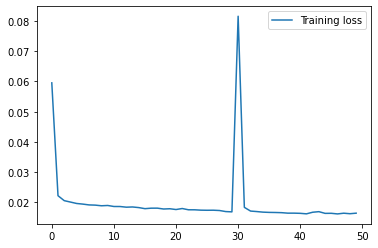

In [14]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1))
opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')
model.summary()

num_epochs = 50
history=model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.legend()

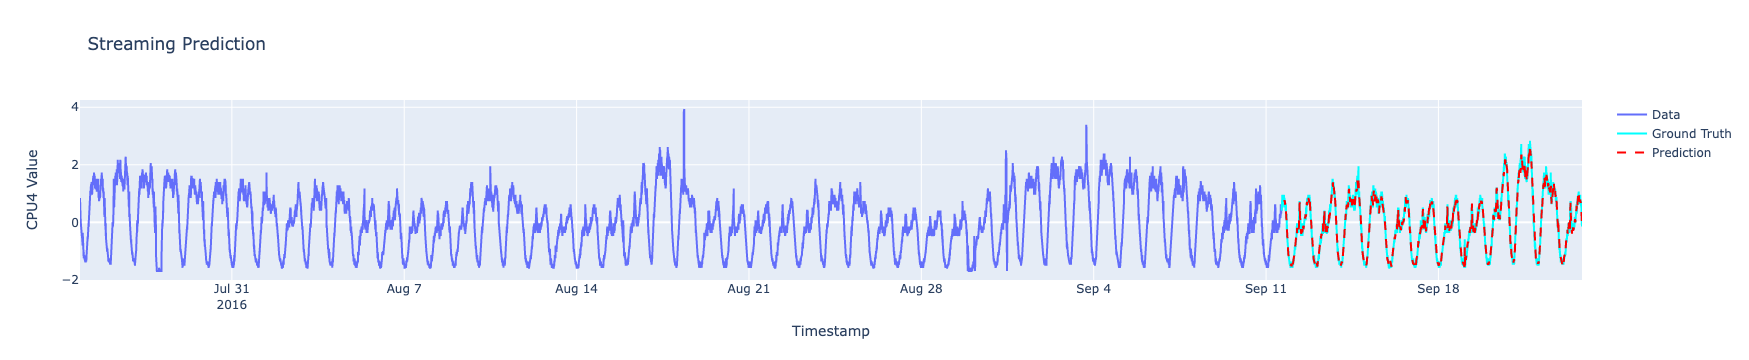

In [17]:
date_pred = date_test[look_back:]
prediction = model.predict_generator(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)

trace2 = go.Scatter(
    x = date_test,
    y = close_test,
    #mode='lines',
    name = 'Ground Truth',
    line=dict(color='cyan', width=2)
)

trace3 = go.Scatter(
    x = date_pred,
    y = prediction,
    #mode = 'lines',
    name = 'Prediction',
    line=dict(color='red', dash='dash')
)
layout = go.Layout(
    title = "Streaming Prediction",
    xaxis = {'title' : "Timestamp"},
    yaxis = {'title' : "CPU4 Value"}
)

fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

In [18]:
print(f"Prediction Shape: {prediction.shape}")

Prediction Shape: (3484,)


1. **"close_train"** is the data set used for the training using a certain percentage to split the dataset
2. **"prediction"** speaks for itself, it is basicaly predicting what will happen on the testing data
3. **"close_test"** is the data set used for the testing using the remaining percentage to compare with the prediction, also known as the "Ground Truth"

# Forecasting

In [19]:
close_data = close_data.reshape((-1))

In [20]:
close_data.shape

(17568,)

In [21]:
def predict(num_prediction, model):
    prediction_list = close_train[-(look_back):]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list

In [22]:
def predict_dates(num_prediction):
    prediction_dates = timestamp[len(close_train)+1:len(close_train)+num_prediction+1] 
    return prediction_dates
    
# def predict_dates(num_prediction):
#     last_date = df['Time'].values[-1]
#     prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
#     return prediction_dates

In [23]:
num_prediction = len(close_test)-1
print(f"Number for predictions: {num_prediction}")

Number for predictions: 3513


In [24]:
print("Forecast")
forecast = predict(num_prediction, model)
forecast

Forecast


array([ 0.62644088,  0.63005304,  0.65969777, ..., -1.39440143,
       -1.40595686, -1.41631067])

In [25]:
print("Forecast Dates")
forecast_dates = predict_dates(num_prediction)
print(forecast_dates)

Forecast Dates
14055   2016-09-11 15:15:00
14056   2016-09-11 15:20:00
14057   2016-09-11 15:25:00
14058   2016-09-11 15:30:00
14059   2016-09-11 15:35:00
                ...        
17563   2016-09-23 19:35:00
17564   2016-09-23 19:40:00
17565   2016-09-23 19:45:00
17566   2016-09-23 19:50:00
17567   2016-09-23 19:55:00
Name: timestamp, Length: 3513, dtype: datetime64[ns]


In [26]:
# def predict_dates(num_prediction):
#     prediction_dates = df['Time'][len(close_train)+1:len(close_train)+num_prediction+1] 
#     return prediction_dates

# predict_dates(5)

In [27]:
# df['Time'].values[-400]

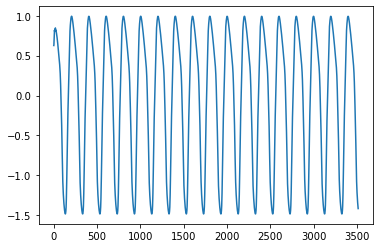

In [28]:
plt.plot(forecast)

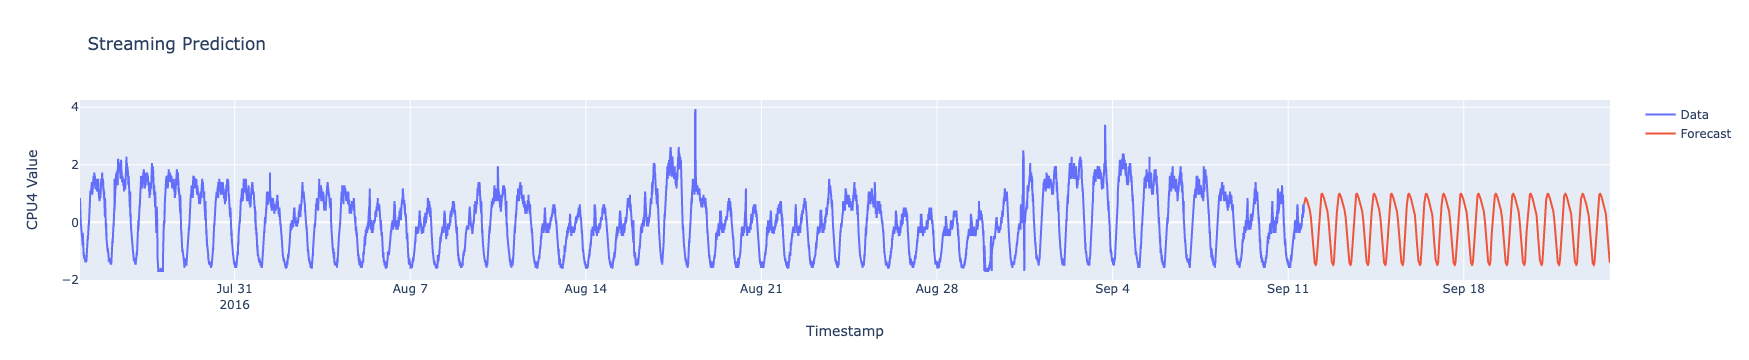

In [29]:
trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)

trace3 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Forecast'
)

layout = go.Layout(
    title = "Streaming Prediction",
    xaxis = {'title' : "Timestamp"},
    yaxis = {'title' : "CPU4 Value"}
)
fig = go.Figure(data=[trace1, trace3], layout=layout)
fig.show()

This prediction behavior is normal because of the propogation from the small error in the begining to propogate into a larger error during the forecast phase